#### IRIS

Wczytanie bibliotek

In [247]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras import Input

from keras.losses import SparseCategoricalCrossentropy

from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import confusion_matrix


Wczytanie danych

In [248]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
y = y.astype(np.int32)
np.unique(y), X.shape

(array([0, 1, 2]), (150, 4))

Podział danych na treningowe i testowe, skalowanie

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

scaler = StandardScaler()
X_train, X_test = \
    scaler.fit_transform(X_train), scaler.transform(X_test)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_ds = train_ds.shuffle(100).batch(8)

Budowa modelu: input - 4 wartości, output - 3 klasy

Ostatnia warstwa ma funkcję aktuwacyjna softmax, gdyż klasyfikacja jest wieloklasowa

In [250]:
model = Sequential()
model.add(Input(shape=(4,)))
model.add(Dense(units=4, activation='relu'))
model.add(Dense(units=400, activation='relu'))
model.add(Dense(units=300, activation='relu'))
model.add(Dense(units=200, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

Info o modelu

In [251]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_119 (Dense)           (None, 4)                 20        
                                                                 
 dense_120 (Dense)           (None, 400)               2000      
                                                                 
 dense_121 (Dense)           (None, 300)               120300    
                                                                 
 dense_122 (Dense)           (None, 200)               60200     
                                                                 
 dense_123 (Dense)           (None, 100)               20100     
                                                                 
 dense_124 (Dense)           (None, 50)                5050      
                                                                 
 dense_125 (Dense)           (None, 3)               

Zmodyfikowany optimizer Adam (i tak wartość learning_rate=default)

In [252]:
adam_optim = keras.optimizers.Adam(learning_rate=1e-3)

Zmodyfikowa loss_function

In [253]:
loss_fn = SparseCategoricalCrossentropy(from_logits=False)

Kompilacja modelu

In [254]:
model.compile(
    # optimizer='adam',
    optimizer=adam_optim,
    loss=loss_fn,
    # loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Scheduler

In [255]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5,
                              patience=5, min_lr=0.0001)

Fitowanie modelu

In [256]:
train_stats = model.fit(train_ds, epochs=50, verbose=0, callbacks=[reduce_lr])

Przebieg uczenia

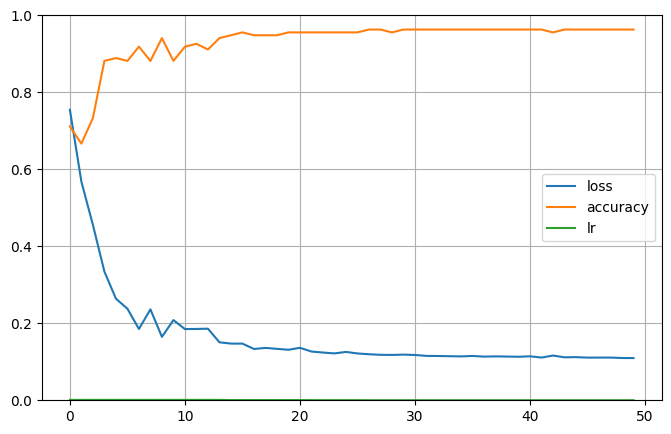

In [257]:
pd.DataFrame(train_stats.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

Parametry modelu

In [258]:
print(f"min loss: {np.asarray(train_stats.history['loss']).min()}, \n\
max accuracy: {np.asarray(train_stats.history['accuracy']).max()}, \n\
max learning rate: {np.asarray(train_stats.history['lr']).max()}, \n\
min learning rate: {np.asarray(train_stats.history['lr']).min()}")

min loss: 0.10963800549507141, 
max accuracy: 0.9629629850387573, 
max learning rate: 0.0010000000474974513, 
min learning rate: 9.999999747378752e-05


Predykcja

In [259]:
Y_pred = model.predict(X_test, verbose=0)
y_pred = [np.argmax(i) for i in Y_pred]
cm = confusion_matrix(y_pred, y_test)

Porównanie prognozowanych klas z rzeczywistymi

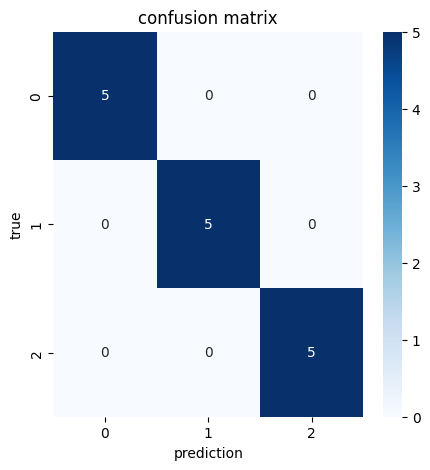

In [260]:
plt.figure(figsize=(5,5))
ax = sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_title('confusion matrix')
ax.set_xlabel('prediction')
ax.set_ylabel('true')
plt.show()

Wynik jest dobry, ale przy wielokrotnym uruchamianiu bywa gorszy, więc model nie jest do końca przewidywalny.